In [19]:
from IPython.display import clear_output
clear_output(wait=True)

import numpy as np
import matplotlib.pyplot as plt

from pprint import pprint as ppr
from queue import Queue


def dist_vu(v : np.ndarray,u : np.ndarray):
    return ((v[0]-u[0])**2. + (v[1]-u[1])**2.)**0.5


def dist_vuxy(v : np.ndarray, ux, uy):
    return ((v[0]-ux)**2. + (v[1]-uy)**2.)**0.5

def dist_vxyuxy(vx,vy,ux,uy):
    return ((vx-ux)**2. + (vy-uy)**2.)**0.5

import math

def around(n):
    if n - math.floor(n) < 0.5:
        return math.floor(n)
    return math.ceil(n)

def next_step_p2t(p : np.ndarray, t : np.ndarray, out : np.ndarray):
    tx,ty = t
    px,py = p
    tp = t - p
    if tp[0]:
        px = px + tp[0]/abs(tp[0])
    if tp[1]:
        py = py + tp[1]/abs(tp[1])
       
    out[0] = px
    out[1] = py

In [108]:
I = np.loadtxt("datadir/waydata.csv",dtype=int).reshape([100,100],order='F')
M = np.loadtxt("datadir/midpoints.csv",dtype=int,delimiter=',')
S = np.loadtxt("datadir/skeleton.csv",dtype=int).reshape([100,100],order='F')


UNKNOWN = -1
NOWAY = 0
ISWAY = 1
MIDWAY = 2
TARGET  = 3
VISITED = 4
SEEN = 5
BEHIND = 6

I[S==1]=MIDWAY

maxview = 50
px = 43
py = 8
st = 0

    
ps = [px,py]
pg = [50,py]

In [109]:
MAP = I[:].copy()

class SquareGrid:
    
    def __init__(self, w, h):
        self.width = w
        self.height = h

    def in_bounds(self, id):
        (x, y) = id
        return 0 <= x < self.width and 0 <= y < self.height

    def neighbord_check(self,results,id):
        (x,y) = id
        if (x + y) % 2 == 0: results.reverse() # aesthetics
        results = filter(self.in_bounds, results)  
        return results
    
    def neighbors4(self, id):
        (x, y) = id
        results = [(x+1,y+0),(x+0,y-1),(x-1,y+0),(x+0,y+1)]
        results = self.neighbord_check(results,id)
        return results

    def neighbors8(self, id):
        (x, y) = id
        results = [(x+1,y+0),(x+1,y-1),(x,y-1),(x-1,y-1),(x-1,y),(x-1,y+1),(x,y+1),(x+1,y+1)]
        results = self.neighbord_check(results,id)
        return results
    
    
def plot_map(MAP,p,g):
    plt.imshow(MAP,cmap=plt.cm.gray)
    plt.plot(p[0],p[1],'bo')
    plt.plot(g[0],g[1],'ro')
                
def do_frontier(MAP):
    
    ny,nx = MAP.shape
    allway = []
    midway = []
    for x in range(nx):
        for y in range(ny):
            if MAP[y,x] == NOWAY:
                continue
            elif MAP[y,x] == ISWAY:
                allway.append((x,y))
            elif MAP[y,x] == MIDWAY:
                midway.append((x,y))
                
    return allway,midway


    
def floof_fill(graph,start,goal,MAP):
    frontier = Queue()
    frontier.put(start )
    came_from = {}
    came_from[start] = None
    print('start ...')
    cnt = 0
    
    PMAP = np.zeros([100,100])
    
    while not frontier.empty():
        current = frontier.get()
        
        if current == goal:
            break
        
        for next in graph.neighbors4(current):
            x,y = next
            cnt += 1
            if cnt % 1000 == 0: print (cnt)
            if MAP[y,x] == NOWAY:
                continue
            else:
                if PMAP[y][x] == 0:
                #if next not in came_from:
                    PMAP[y][x] = 1
                    frontier.put(next)
                    came_from[next] = current
                    
    print('end...',cnt)
    return came_from
    
def traverse_back(goal,start,came_from):
    current = goal 
    path = []
    while current != start: 
        path.append(current)
        current = came_from[current]
    path.append(start) # optional
    path.reverse() # optional
    return path
    
def main(MAP,p,g):
    n,m = MAP.shape
    plt.figure(figsize=(20,17))

    #allway,midway = do_frontier(MAP.T)
    
    graph = SquareGrid(m,n)
    
    camefrom = floof_fill(graph,tuple(p),tuple(g),MAP)
    
    for k in camefrom:
        v = camefrom[k]
        kx,ky = k 
        #plt.plot(kx,ky,'g.')
        if v is not None:
            vx,vy = v
            MAP[vy,vx] = SEEN
            #plt.plot(vx,vy,'g*')
        MAP[ky,kx] = SEEN
        
    
    path1 = traverse_back(tuple(g),tuple(p),camefrom)
    path1 = np.c_[path1]
    
    pathlen = path1.shape[0]
    splits = 50
    chunksize = pathlen//splits
    targets = []
    for i in range(splits):
        j = min(pathlen-1,i*chunksize)
        targets.append(path1[j])
    targets.append(g)
    targets = np.c_[targets]
    plt.plot(path1[:,0],path1[:,1],'g.-')
    plt.plot(targets[:,0],targets[:,1],'b*-')
    plot_map(MAP,p,g)
    
    plt.show()
    
main(MAP,ps,pg)

start ...
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
end... 17580


In [ ]:
def dijkstra_search(graph, start, goal):
    frontier = PriorityQueue()
    frontier.put(start, 0)
    came_from = {}
    cost_so_far = {}
    came_from[start] = None
    cost_so_far[start] = 0
    
    while not frontier.empty():
        current = frontier.get()
        
        if current == goal:
            break
        
        for next in graph.neighbors(current):
            new_cost = cost_so_far[current] + graph.cost(current, next)
            if next not in cost_so_far or new_cost < cost_so_far[next]:
                cost_so_far[next] = new_cost
                priority = new_cost
                frontier.put(next, priority)
                came_from[next] = current
    
    return came_from, cost_so_far

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 1 1 0]]
[[44  8]
 [49  8]]
1 1


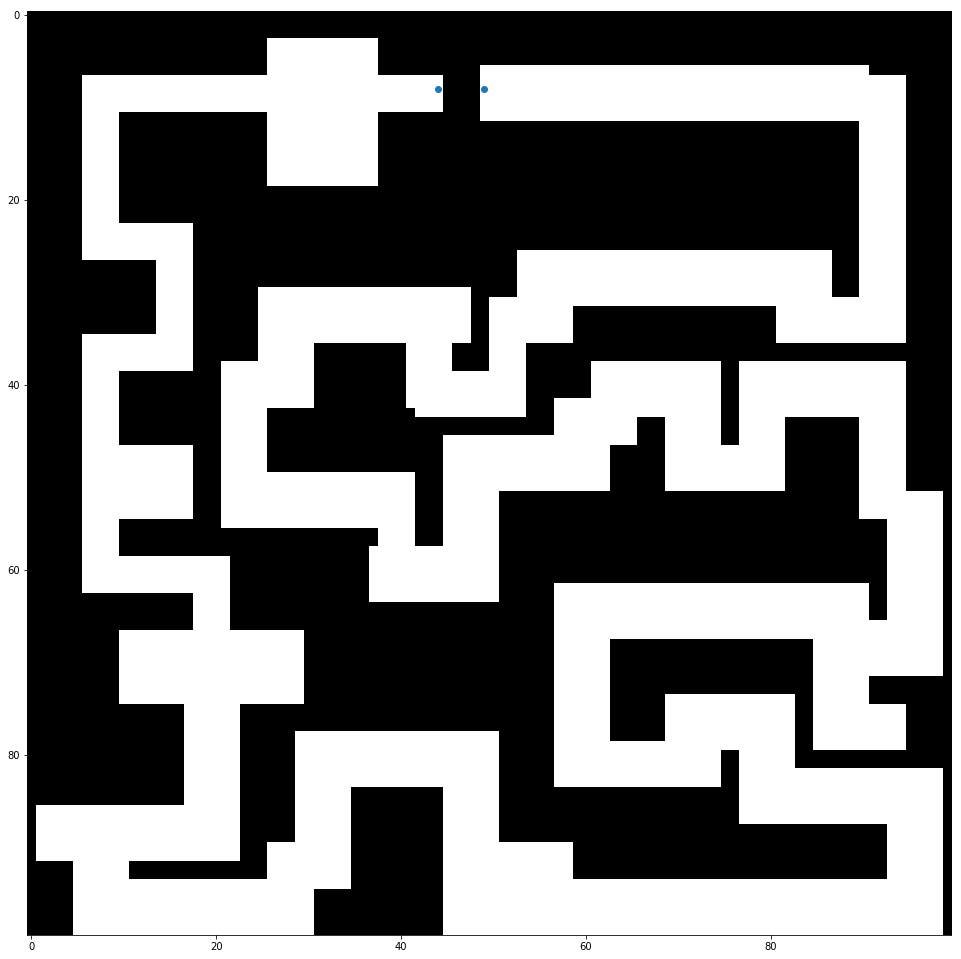

In [103]:
I = np.loadtxt("datadir/waydata.csv",dtype=int).reshape([100,100],order='F')
SE = np.loadtxt("datadir/startend.csv",dtype=int,delimiter=',').reshape([2,2],order='F')
print(I)
print(SE)
ps,pe = SE
print(I[ps[0],ps[1]],I[pe[0],pe[1]])
plt.figure(figsize=(20,17))
plt.imshow(I,cmap=plt.cm.gray)
plt.plot(SE[:,0],SE[:,1],'o')
plt.show()

In [112]:
I = np.loadtxt("datadir/waydata.csv",dtype=int).reshape([100,100],order='C')
SE = np.loadtxt("datadir/startend.csv",dtype=int,delimiter=',').reshape([2,2],order='F')
ps,pg = SE
ps[1]-=1
pg[1]+=1
print(ps,pg)
P = np.loadtxt("datadir/pathstartwin.csv",dtype=int,delimiter=',')
print(P)

plt.figure(figsize=(20,17))
plt.imshow(I.T,cmap=plt.cm.gray)
plt.plot(SE[:,0],SE[:,1],'o')


plt.plot(P[:,0],P[:,1],'g.-')

plt.show()

[44  7] [49  9]
[[44  8]
 [44  9]
 [43  9]
 ...
 [51  8]
 [50  8]
 [49  8]]
